In [266]:
import numpy as np
import nashpy as nash
import matplotlib.pyplot as plt

def find_the_equilibrium(g):
# Function that returns the one optimal equilibrium using different methods from nashpy
	arr, arr_1 = [], []

	lhs = g.lemke_howson_enumeration()
	for lh in lhs:
		arr.append(lh)

	# Check if lemke_howson's output is is all the same (only first 2 outputs for simplicity)
	if np.array_equal(arr[0], arr[1]):
		# If so then that is the corret equlibrium
		return arr[0]

	else: # Return 3rd output of the support_enumeration method 
		#(TODO: check if it's the same with 2nd output of vertex_enumeration (it should be))
		eqs = g.support_enumeration()
		for eq in eqs:
			arr_1.append(eq)
		return arr_1[-1]

In [ ]:
# Prisoner's Dilemma
pd = nash.Game(np.array([[3, 0], [5, 1]]), np.array([[3, 5], [0, 1]]))

# Negative Prisoner's Dilemma
pd_negative = nash.Game(np.array([[-3, -10], [0, -5]]), np.array([[-3, 0], [-10, -5]]))

# Game of Chicken
chicken = nash.Game(np.array([[0, -1], [1, -10]]), np.array([[0, 1], [-1, -10]]))

# Stug Hunt
hunt = nash.Game(np.array([[5, 0], [2, 1]]), np.array([[5, 2], [0, 1]]))

# Stug Hunt
coop_hunt = nash.Game(np.array([[5, 1], [1, 1]]), np.array([[5, 1], [1, 1]]))

# Matching Pennies
mp = nash.Game(np.array([[1, -1], [-1, 1]]), np.array([[-1, 1], [1, -1]]))

# Battle of the Sexes
bos = nash.Game(np.array([[1, 0], [0, 2]]), np.array([[2, 0], [0, 1]]))

# Test Game
test = nash.Game(np.array([[1, 0.9999], [1, 1.00001]]), np.array([[1, 1.00001], [1, 1]]))

games = {
    "Prisoner's dilemma": pd,
    "Prisoner's dilemma (negative pay-offs)": pd_negative,
    "Game of Chicken": chicken,
    "Stug Hut": hunt,
    "Matching Pennies": mp,
    "Battle of the Sexes": bos,
    "Test game": test}

In [ ]:
def epic_vertic(principal_game, agents_game):
    # for measuring vertical alignment

    principal_row = principal_game.payoff_matrices[0]
    principal_col = principal_game.payoff_matrices[1]

    agent_row = agents_game.payoff_matrices[0]
    agent_col = agents_game.payoff_matrices[1]

    # note: uniform distribution assumed
    row_matrix_coeffs = np.corrcoef(
        [principal_row.flatten(), agent_row.flatten()])
    col_matrix_coeffs = np.corrcoef(
        [principal_col.flatten(), agent_col.flatten()])
    return (row_matrix_coeffs[0][1], col_matrix_coeffs[0][1])

In [ ]:
def experiment(game=None, epsilon_r=None, epsilon_c=None):

	"""
	TODO: Add an ability to pass v_alignment and h_alignment inot the function!
		if that is possible - it seems to be an outcome of the pay-offs which would mean that
		changing the alignment would have to change the game pay-offs

	When passing games make sure the the pay-offs are normalize (e.g. thought an affine
	transformation) into a range [0, 1].

	principals_game is fully random (both row and column pay-offs are randomly generated)
	"""

    # (1) Sample G and G' from uniform distribution [-1, 1]
	if game is None:
		agents_game = nash.Game(np.random.uniform(-1, 1, size=(2,2)), np.random.uniform(-1, 1, size=(2,2)))
		principals_game = nash.Game(np.random.uniform(-1, 1, size=(2,2)), np.random.uniform(-1, 1, size=(2,2)))
	else:
		agents_game = nash.Game(pd.payoff_matrices[0])
		principals_game = nash.Game(pd.payoff_matrices[1])

    # (2) Sample epsilons (and a random strategy) from a uniform distribution [0, 1], 
	# where 1 playing NE and 0 is playing at random. 
	# note that when playing at random it's possible that the agent will end up playing NE (or well).
	if epsilon_c is None:
		epsilon_c = np.random.uniform(0, 1)
	if epsilon_r is None:
		epsilon_r = np.random.uniform(0, 1)
	random_strategy = np.random.uniform(0, 1)
		
	# (3) Compute Game's Equilibrium (both pure and mixed) and define the best strategies
	strategies = find_the_equilibrium(agents_game)
	row_strat = strategies[0]
	col_strat = strategies[1]
	
	# (4) Adjust strategies by epsilon
	row_strat = row_strat * epsilon_r + random_strategy * (1 - epsilon_r)
	col_strat = col_strat * epsilon_c + random_strategy * (1 - epsilon_c)
	adjusted_strategies = [row_strat, col_strat]

    # (5) Compute Vertical and Horizontal Alignment, and Principal's Welfare
	# Horizontal alignment 
	row_payoffs = agents_game.payoff_matrices[0]
	col_payoffs = agents_game.payoff_matrices[1]
	matrix_coeffs = np.corrcoef([row_payoffs.flatten(), col_payoffs.flatten()])
	h_alignment = matrix_coeffs[0][1] # this returns a matrix from which we only need a single variable
	h_alignment = (h_alignment + 1) / 2

	# Vertical alignemnt (note: that this returns the alignmetn between row and col pay-offs seperately)
	v_alignment = epic_vertic(principals_game, agents_game)
	# this returns a tuple (row, col) metrics, so let's get an average alignment TODO: confirm this is correct!
	v_alignment = (v_alignment[0] + v_alignment[1]) / 2
	v_alignment = (v_alignment + 1) / 2

	# Principal's Welfare (Calculate the utilities for the Principal given Agents strategies)
	# Note that you you are given the expected pay-offs for both the principle and the other agent
	principal_welf = principals_game[adjusted_strategies][0]
		# TODO: normalize this to [0, 1]

	return principal_welf, epsilon_r, epsilon_c, h_alignment, v_alignment
	

experiment()

### Run the funciton (generate data)

(0.00393506543311641, 0.020452466482618892, 0.054849747482847655, 1.1102230246251565e-16, 0.15254237288135597)



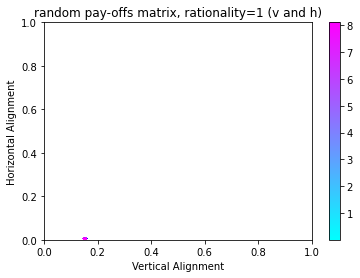

In [268]:
data = []
for i in range(5000):
    data.append(experiment(game=pd))

data = sorted(data, key=lambda x: x[0])

for d in data[:1]:
    print(d)
    print("")

# Extract x and y values from data
x = [d[4] for d in data] # alignment vertical
y = [d[3] for d in data] # alignment horizontal
z = [d[0] for d in data] # principal pay-welfare

# Create a scatter plot
plt.scatter(x, y, c=z, cmap='cool', marker="x", s=10)

# Set the x and y axis limits to 0 and 1
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.colorbar()

# Add x and y axis labels
plt.xlabel('Vertical Alignment')
plt.ylabel('Horizontal Alignment')
plt.title("random pay-offs matrix, rationality=1 (v and h)")

# Show the plot
plt.show()

### Plot the data

In [ ]:
# VARIABLES CHEATSHEET
a = [d[0] for d in data] # principal pay-welfare
a = [d[1] for d in data] # capability row player
a = [d[2] for d in data] # capability col player
a = [d[3] for d in data] # alignment horizontal
a = [d[4] for d in data] # alignment vertical

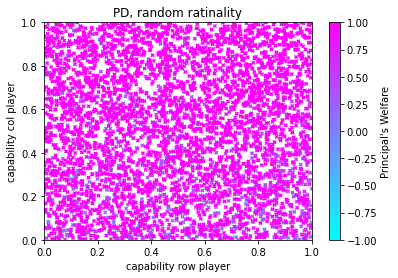

In [270]:
# Extract x and y values from data
x = [d[1] for d in data] # capability row player
y = [d[2] for d in data] # capability col player
z = [d[0] for d in data] # principal pay-welfare

# Create a scatter plot
plt.scatter(x, y, c=z, cmap='cool', marker="x", s=10)

# Set the x and y axis limits to 0 and 1
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.clim(-1, 1)

cb = plt.colorbar()
cb.set_label("Principal's Welfare")

# Add x and y axis labels
plt.xlabel('capability row player')
plt.ylabel('capability col player')

plt.title("PD, random ratinality")

# Show the plot
plt.show()